In [1]:
import torch
import equitorch

/home/Xenadon/miniconda3/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/Xenadon/miniconda3/lib/python3.12/site-packages/libpyg.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/Xenadon/miniconda3/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/Xenadon/miniconda3/lib/python3.12/site-packages/libpyg.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
import torch
import torch.nn as nn
from typing import Tuple
from functools import lru_cache

import torch
from torch import Tensor

from torch_geometric.utils import scatter

import e3nn
from e3nn import o3
from e3nn.o3._s2grid import _quadrature_weights


from equitorch.utils.indices import check_degree_range, degrees_in_range, orders_in_degree_range

def s2_grid(num_thetas: int, num_phis: int, device = None, dtype = None):
    r"""
    Returns the regular grid points on a sphere as defined by the spherical coordinates theta and phi.

    The grid points are calculated according to the following formulas:

    .. math::
        \begin{aligned}
        \theta_i &= \pi\cdot\frac{(i+\frac{1}{2})}{N}, &i = 0,1,\dots N-1,\\
        \phi_j &= 2\pi\cdot\frac{j}{M}, &j = 0,1,\dots M-1,
        \end{aligned}

    where :math:`N` and :math:`M` are the number of points along the 
    :math:`\theta` and :math:`\phi` axes, respectively.

    Parameters
    ----------
    num_thetas : int
        The number of grid points along the :math:`\theta` axis.
    num_phis : int
        The number of grid points along the :math:`\phi` axis.
    device : optional
        The device to store the resulting tensors on. Defaults is None.
    dtype : torch.dtype, optional
        The data type of the resulting tensors. Defaults is None.

    Returns
    -------
    (Tensor, Tensor)
        A tuple of two tensors of the grid points along the :math:`\theta` and :math:`\phi` axes.
    """
    return o3.s2_grid(num_thetas, num_phis, dtype, device)
class ISHT(nn.Module):
    def __init__(self, L: Tuple[int, int], num_thetas: int, num_phis: int, dtype=None, device='cpu'):
        super().__init__()
        assert num_thetas % 2 == 0
        self.L = L
        self.num_thetas = num_thetas
        self.num_phis = num_phis
        
        # Initialize buffers immediately
        thetas, phis = s2_grid(num_thetas, num_phis, device, dtype)
        
        # Compute weighted Legendre polynomials
        weighted_legendre = o3.Legendre(list(degrees_in_range(L)))(
            thetas.cos(), thetas.sin().abs()).unsqueeze(-1)  # [num_thetas, M, 1]
        
        # Compute Fourier components
        fourier = o3.spherical_harmonics_alpha(L[1], phis).unsqueeze(0)  # [1, num_phis, m]
        
        # Get m indices
        m_in_range = orders_in_degree_range(L, device=device)
        
        # Register buffers
        self.register_buffer('weighted_legendre', weighted_legendre)
        self.register_buffer('fourier', fourier)
        self.register_buffer('m_in_range', m_in_range)

    def forward(self, X: torch.Tensor):
        '''
        X must be of shape [...,M,C]
        '''
        X_ = X.view(-1, 1, X.shape[-2], X.shape[-1])
        inter = X_ * self.weighted_legendre
        reduced_l = scatter(inter, self.m_in_range, dim=-2).flatten(0, 1)  # ([...,theta),m,C]
        return (self.fourier @ reduced_l).view(*(X.shape[:-2]), self.num_thetas, self.num_phis, X.shape[-1])


class SHT(nn.Module):
    def __init__(self, L: Tuple[int, int], num_thetas: int, num_phis: int, dtype=None, device='cpu'):
        super().__init__()
        assert num_thetas % 2 == 0
        self.L = L
        self.num_thetas = num_thetas
        self.num_phis = num_phis
        
        # Initialize buffers immediately
        thetas, phis = s2_grid(num_thetas, num_phis, device, dtype)
        
        # Compute quadrature weights
        weight = torch.pi * 4 * _quadrature_weights(num_thetas // 2, dtype=dtype, device=device) 
        weight *= num_thetas**2 / num_phis
        
        # Compute weighted Legendre polynomials
        weighted_legendre = o3.Legendre(list(degrees_in_range(L)))(
            thetas.cos(), thetas.sin().abs()) * weight.unsqueeze(-1)  # [num_thetas, M]
        
        # Compute Fourier components
        fourier = o3.spherical_harmonics_alpha(L[1], phis).transpose(-1, -2)  # [1, m, num_phis]
        
        # Get m indices
        m_in_range = orders_in_degree_range(L, device=device)
        
        # Register buffers
        self.register_buffer('weighted_legendre', weighted_legendre)
        self.register_buffer('fourier', fourier)
        self.register_buffer('m_in_range', m_in_range)

    def forward(self, x: torch.Tensor):
        '''
        x must be of shape [...,theta,phi,C]
        '''
        inter = self.fourier @ x  # ...,theta, m, C
        expand_l = inter.index_select(-2, self.m_in_range)  # ..., theta, M, C
        return torch.einsum('...tMC,tM->...MC', expand_l, self.weighted_legendre).unflatten(0, x.shape[:-3])

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def plot_heatmaps(*tensor_list):
    num_rows = len(tensor_list)  # 纵向行数
    max_subplots = max(tensor.shape[0] for tensor in tensor_list)  # 找出最大子图数
    
    # 创建图形，行数为num_rows，列数为max_subplots
    fig, axes = plt.subplots(num_rows, max_subplots, 
                            figsize=(2*max_subplots, 2*num_rows),
                            squeeze=False)
    
    for row_idx, tensor in enumerate(tensor_list):
        N = tensor.shape[0]  # 当前行的子图数
        
        for col_idx in range(max_subplots):
            ax = axes[row_idx, col_idx]
            
            if col_idx < N:
                # 绘制有效子图
                heatmap = tensor[col_idx, :, :, 0]
                im = ax.imshow(heatmap, cmap='viridis')
                ax.axis('off')
                ax.set_title(f'Row {row_idx+1}-{col_idx+1}')
                
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            else:
                # 隐藏多余的空子图
                ax.axis('off')
        
        # 添加行标题（如果有）
    
    plt.tight_layout()
    plt.show()
# 示例使用

In [11]:
N = 64
l = 1
X = torch.randn(N, 2*l+1, 1)
X = X / X.norm(dim=-2, keepdim=True) * 5
L = (l,l)
thetas, phis = 64, 64
isht = ISHT(L, thetas, phis)
sht = SHT(L, thetas, phis)

In [21]:
x = isht(X)
# x1 = x**2
# x1 = torch.nn.functional.relu(x)
# x1 = torch.abs(x)
x1 = (torch.atan(x)) * x


In [22]:
X1 = sht(x1)

In [25]:
(X1/X)[:,:,0] 

tensor([[ 1.0975e-16,  2.0287e-16,  2.4292e-16],
        [ 9.1583e-18, -1.1327e-16,  5.7622e-17],
        [-1.1560e-16,  7.0483e-17,  8.6794e-17],
        [-3.4137e-17, -3.1386e-15,  1.1687e-16],
        [ 4.8727e-17,  1.1725e-16, -8.4859e-17],
        [-1.5814e-16, -6.5492e-17, -1.5759e-16],
        [ 9.9995e-17,  4.7023e-17, -9.1566e-17],
        [-1.7226e-17,  3.7486e-16, -6.7987e-17],
        [-8.6837e-17, -7.9039e-17,  2.7064e-16],
        [-2.0556e-17, -1.1333e-16,  7.4749e-17],
        [ 5.9505e-18,  1.2710e-17, -1.0255e-16],
        [-3.2289e-17,  1.7690e-15, -1.1746e-16],
        [-4.5488e-17,  7.6497e-18, -6.6261e-17],
        [-1.1659e-18, -6.9523e-17, -5.3188e-18],
        [ 5.8969e-17, -1.2696e-16,  6.4182e-16],
        [-5.6356e-17, -1.0526e-16, -7.8794e-18],
        [-6.9595e-17,  9.7701e-18, -4.6566e-17],
        [-1.6693e-17,  5.4162e-17,  1.1461e-16],
        [-1.6139e-17, -2.1168e-16, -1.2731e-16],
        [ 7.7428e-17,  1.3718e-16, -1.8275e-16],
        [ 5.6240e-17

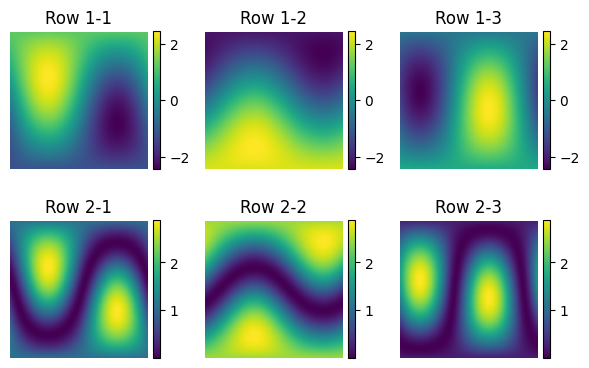

In [26]:
plot_heatmaps(x[:3], x1[:3])

In [33]:
x.shape

torch.Size([64, 64, 64, 1])